In [9]:
import matplotlib.pyplot as plt
import cmasher as cmr
import numpy as np
from unyt import Myr, K


In [10]:
# set style
# plt.style.use('../../matplotlibrc.txt')

### Read in Galaxy object

In [11]:
import pickle

# Define object ID
id = '145492'

# Initialise Galaxy object
galaxy = pickle.load(open(f'data/galaxy_{id}.pck','rb'))

### Initialise a SPS grid

In [12]:
from synthesizer.grid import Grid

grid_dir = '/Users/sw376/Dropbox/Research/data/synthesizer/grids/'
grid_name = 'bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps'

# initialise the grid, but with a restricted wavelength range and resolution
grid = Grid(grid_name, grid_dir=grid_dir)

grid.lam.shape

(9244,)

### Create the incident (pure stellar) spectra

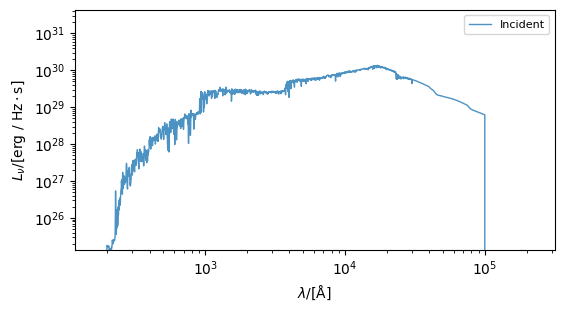

In [13]:
from synthesizer.emission_models import IncidentEmission

# reset spectra
galaxy.stars.spectra = {}

# generate integrated spectra
galaxy.stars.get_spectra(IncidentEmission(grid=grid))

# plot spectra
fig, ax = galaxy.stars.plot_spectra(show=True, figsize=(6, 4))

### Create dust attenuated spectra

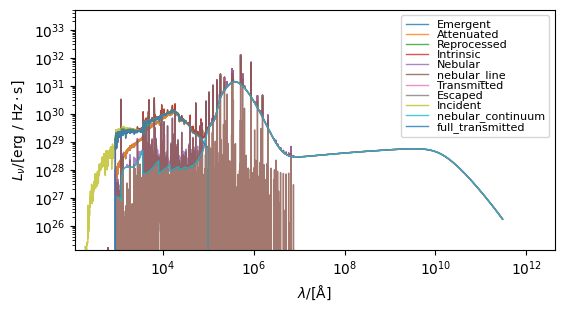

In [14]:
from synthesizer.emission_models import PacmanEmission, ScreenEmission
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emission_models.dust.emission import Blackbody, Greybody

# specify a power-law dust curve
alpha = -1.0 # dust curve slope
dust_curve = PowerLaw(slope=alpha)

# dust emission
dust_emission = Blackbody(temperature=30*K)

# Define the emission model, in this case Screen emission which just allows you to define tau_v for each particle
emission_model = ScreenEmission(
    grid=grid, 
    # tau_v="tau_v", # this currently breaks due to memory requirements
    tau_v=0.5, 
    dust_curve=dust_curve,
    fesc=0.0,
    fesc_ly_alpha=1.0,
    # per_particle=True,
    )

galaxy.stars.spectra = {} # reset spectra
galaxy.stars.get_spectra(emission_model)
spectra = galaxy.stars.spectra
fig, ax = galaxy.stars.plot_spectra(show=True, figsize=(6, 4))

ax.set_xlim([1E2, 1E5])

plt.show()


### Get photometry  

In [15]:
from synthesizer.filters import FilterCollection


# Get the filter collection
nircam_filters = [
    f"JWST/NIRCam.{f}"
    for f in ["F070W", "F090W", "F115W", "F150W", "F200W", "F277W", "F356W", "F444W"]
]


filters = FilterCollection(
    filter_codes=nircam_filters,
    new_lam=grid.lam,
)





/var/folders/1r/dyc06cz53k1g87b17q09by98000ft2/T/ipykernel_14863/690240001.py:1: FutureWarning: The filters module has been moved to the instruments module. Please update your imports synthesizer.filters -> synthesizer.instruments
  from synthesizer.filters import FilterCollection


### Make production figure

JWST/NIRCam.F070W 7039.1194650653715 Å 3.386020856345799 nJy
JWST/NIRCam.F090W 9021.528592183862 Å 29.228506875455643 nJy
JWST/NIRCam.F115W 11542.608549288077 Å 46.9952603186897 nJy
JWST/NIRCam.F150W 15007.438277814035 Å 79.19159228871594 nJy
JWST/NIRCam.F200W 19886.48348846672 Å 111.55535236696801 nJy
JWST/NIRCam.F277W 27617.397876982246 Å 193.25527140719663 nJy
JWST/NIRCam.F356W 35683.61910985526 Å 401.1303257540834 nJy
JWST/NIRCam.F444W 44043.150924134556 Å 510.820983248722 nJy


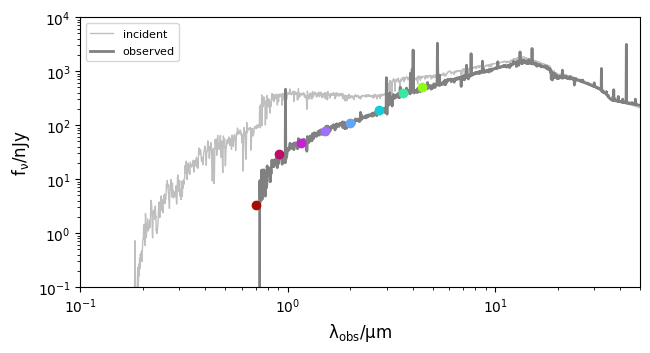

In [16]:
from astropy.cosmology import Planck18 as cosmo
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from synthesizer.grid import Grid
import cmasher as cmr





wavelength_limits = [-1., 3.]
flux_limits = [-1., 4.]

wavelength_limits = [0.1, 5E1]
flux_limits = [0.1, 1E4]


# set style
# plt.style.use('../../matplotlibrc.txt')


fig = plt.figure(figsize=(7.0, 4.5))

left = 0.15
width = 0.8
bottom = 0.1
height = 0.6

ax = fig.add_axes((left, bottom, width, height))


reference_metallicity = 0.01

grid_point = (0, 5)

# sed = spectra['incident']
# ax.plot(np.log10(sed.lam), np.log10(sed.lnu), lw=2, c='0.8', alpha=0.3)

# sed = spectra['intrinsic']
# ax.plot(np.log10(sed.lam), np.log10(sed.lnu), lw=1, c='0.5', alpha=1.0)


# for sed_name, sed in spectra.items():
#     sed.get_fnu(z=7., cosmo=cosmo)
#     ax.loglog(
#     sed.obslam.to('um').value, 
#     sed.fnu.to('nJy').value, 
#     lw=1, 
#     c='k', 
#     alpha=0.5, 
#     zorder=0,)

sed = spectra['incident']
sed.get_fnu(z=7., cosmo=cosmo)

ax.loglog(
    sed.obslam.to('um').value, 
    sed.fnu.to('nJy').value, 
    lw=1, 
    c='0.5', 
    alpha=0.5, 
    zorder=0,
    label=r'$\rm incident$')


sed = spectra['emergent']
sed.get_fnu(z=7., cosmo=cosmo)

ax.loglog(
    sed.obslam.to('um').value, 
    sed.fnu.to('nJy').value, 
    lw=2, 
    c='0.5', 
    alpha=1.0, 
    zorder=1,
    label=r'$\rm observed$')

# get photometry

photometry = sed.get_photo_fnu(filters)


colours = cmr.take_cmap_colors('cmr.neon', len(filters))

for filter_code, colour in zip(photometry.filter_codes, colours):
    filter = photometry.filters[filter_code]
    print(filter_code, filter.pivwv(), photometry[filter_code])
    ax.scatter(
        filter.pivwv().to('um').value,
        photometry[filter_code].to('nJy').value,
        color=colour,
        zorder=2)

ax.legend(fontsize=8)

ax.set_xlim(wavelength_limits)
ax.set_ylim(flux_limits)

ax.set_ylabel(r'$\rm f_{\nu}/nJy$', fontsize=12)
ax.set_xlabel(r'$\rm \lambda_{obs}/\mu m$', fontsize=12)

fig.savefig(f'figs/tng_spectra.pdf')
plt.show()
fig.clf()